In [1]:
import os
import re
#import kagglehub
from tools.config import get_config_for_7b, get_config_for_2b
import tools.config as gemma_config
from tools.model import Sampler, Embedding, precompute_freqs_cis
from tools.model_utils import GemmaLayerModel, GemmaLastLayerModel, load_model
from tools.tokenizer import Tokenizer
import torch
from torch import nn
from typing import Any, List, Optional, Sequence, Tuple, Union
from deepeval.benchmarks import MMLU, HellaSwag
from deepeval.benchmarks.tasks import MMLUTask, HellaSwagTask
from deepeval.models.base_model import DeepEvalBaseLLM
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

/home/sirera.m/.local/lib/python3.9/site-packages/deepeval/__init__.py:42: UserWarning: You are using deepeval version 0.21.39, however version 0.21.48 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


In [2]:
# Machine type
VARIANT = '1.1-2b-it'
MACHINE_TYPE = 'cuda'

In [3]:
# Download tokenizer
home_dir = os.path.expanduser("~")
weights_dir = os.path.join(home_dir, ".cache", "kagglehub", "models", "google", "gemma", "pyTorch", VARIANT)
weights_dir = os.path.join(weights_dir, "1") if '1.1' in VARIANT else os.path.join(weights_dir, "2")
if not os.path.exists(weights_dir):
    kagglehub.login() # API KEY: 5cb66339276d4bea7ba59ca714d28f6b
    weights_dir = kagglehub.model_download(f'google/gemma/pyTorch/{VARIANT}')
tokenizer_path = os.path.join(weights_dir, 'tokenizer.model')
assert os.path.isfile(tokenizer_path), 'Tokenizer not found!'

In [4]:
# Define config
config = get_config_for_2b() if "2b" in VARIANT else get_config_for_7b()
config.tokenizer = tokenizer_path
config.quant = 'quant' in VARIANT
torch.set_default_dtype(config.get_dtype())
device = torch.device('cuda' if torch.cuda.is_available() and MACHINE_TYPE == 'cuda' else 'cpu')

In [10]:
class GemmaForCausalLM(nn.Module):
    def __init__(
        self,
        config: gemma_config.GemmaConfig,
    ):
        super().__init__()
        self.config = config
        assert config.hidden_size % config.num_attention_heads == 0

        max_seq_len = config.max_position_embeddings
        head_dim = config.head_dim
        vocab_size = config.vocab_size

        self.tokenizer = Tokenizer(config.tokenizer)
        self.embedder = self.initialize_embedder(vocab_size)
        self.model = self.initialize_model()
        self.sampler = Sampler(vocab_size).to(device)

        # Pre-compute rotary embedding table.
        rope_theta = getattr(config, 'rope_theta', 10000)
        self.freqs_cis = precompute_freqs_cis(head_dim,
                                         max_seq_len * 2,
                                         theta=rope_theta).to(device)
        
    def initialize_model(
        self,
    ):
        # Initialize and load splits
        model = [GemmaLayerModel(self.config) for layer in range(self.config.num_hidden_layers - 1)]
        model.append(GemmaLastLayerModel(self.config))
        for layer in range(self.config.num_hidden_layers):
            load_model(model[layer], f'./weights/{VARIANT}/layer_model_{layer}.pth')
        model = [layer.to(device).eval() for layer in model]
        return model

    def initialize_embedder(
        self,
        vocab_size
    ):
        # Initialize embedder
        embedder = Embedding(vocab_size, self.config.hidden_size, self.config.quant).to(device)
        embedding_weights = torch.load(f'./weights/{VARIANT}/embedding_weights.pth', map_location=device)
        embedder.load_state_dict(embedding_weights)
        return embedder

    def forward_pass(
        self,
        output_index,
        opt_ixs,
        j, # Layer to skip if not none
        input_token_ids: torch.Tensor,
        input_positions: torch.Tensor,
        kv_write_indices: torch.Tensor,
        kv_caches: List[Tuple[torch.Tensor, torch.Tensor]],
        mask: torch.Tensor,
        output_positions: torch.Tensor,
        temperatures: Union[torch.Tensor, None],
        top_ps: torch.Tensor,
        top_ks: torch.Tensor,
        **kwargs,
    ) -> torch.Tensor:
        freqs_cis = self.freqs_cis.index_select(0, input_positions)
        kv_write_indices = input_positions

        # [batch_size, input_len, hidden_size]
        hidden_states = self.embedder(input_token_ids)
        # Gemma normalizes the embedding by sqrt(hidden_size).
        hidden_states = hidden_states * (self.config.hidden_size**0.5)
        with torch.no_grad():
            for i in range(self.config.num_hidden_layers):
                if j is not None and i in j:
                    #print(f'Skipped layer {i}')
                    continue
                hidden_states = self.model[i](
                    hidden_states=hidden_states,
                    freqs_cis=freqs_cis,
                    kv_write_indices=kv_write_indices,
                    kv_cache=kv_caches[i],
                    mask=mask,
                )
        embedder_weight = self.embedder.weight
        if self.config.quant:
            embedder_weight = (
                embedder_weight * self.embedder.weight_scaler.unsqueeze(-1))
        
        hidden_states = hidden_states.index_select(
            1, output_positions).squeeze(dim=1)
        logits = torch.matmul(hidden_states, embedder_weight.t())
        # Selecting only certain indices from the logits tensor
        selected_logits = logits[:, opt_ixs]
        return torch.argmax(selected_logits, dim=-1).squeeze(dim=-1)
        #next_tokens = self.sampler(
        #    embedding=embedder_weight,
        #    hidden_states=hidden_states,
        #    output_positions=output_positions,
        #    temperatures=temperatures,
        #    top_ps=top_ps,
        #    top_ks=top_ks,
        #)
        #return next_tokens

    def generate(
        self,
        prompts: Union[str, Sequence[str]],
        device: Any,
        lts: Union[int, Sequence[int], None],
        output_len: int = 1,
        temperature: Union[float, None] = 0.95,
        top_p: float = 1.0,
        top_k: int = 100,
    ) -> Union[str, Sequence[str]]:
        """Generates responses for given prompts using Gemma model."""
        options = ['A', 'B', 'C', 'D']
        opt_ixs = [self.tokenizer.encode(letter)[1] for letter in options]
        # If a single prompt is provided, treat it as a batch of 1.
        is_str_prompt = isinstance(prompts, str)
        if is_str_prompt:
            prompts = [prompts]
        is_lts_int = isinstance(lts, int)
        if is_lts_int:
            lts = [lts]

        batch_size = len(prompts)
        prompt_tokens = [self.tokenizer.encode(prompt) for prompt in prompts]
        min_prompt_len = min(len(p) for p in prompt_tokens)
        max_prompt_len = max(len(p) for p in prompt_tokens)
        max_seq_len = max_prompt_len + output_len
        assert max_seq_len <= self.config.max_position_embeddings

        # build KV caches
        kv_caches = []
        for _ in range(self.config.num_hidden_layers):
            size = (batch_size, max_seq_len, self.config.num_key_value_heads,
                    self.config.head_dim)
            dtype = self.config.get_dtype()
            k_cache = torch.zeros(size=size, dtype=dtype, device=device)
            v_cache = torch.zeros(size=size, dtype=dtype, device=device)
            kv_caches.append((k_cache, v_cache))

        # prepare inputs
        token_ids_tensor = torch.full((batch_size, max_seq_len),
                                      self.tokenizer.pad_id, dtype=torch.int64)
        input_token_ids_tensor = torch.full((batch_size, min_prompt_len),
                                            self.tokenizer.pad_id,
                                            dtype=torch.int64)
        for i, p in enumerate(prompt_tokens):
            token_ids_tensor[i, :len(p)] = torch.tensor(p)
            input_token_ids_tensor[i, :min_prompt_len] = torch.tensor(
                p[:min_prompt_len])
        token_ids_tensor = token_ids_tensor.to(device)
        input_token_ids_tensor = input_token_ids_tensor.to(device)
        prompt_mask_tensor = token_ids_tensor != self.tokenizer.pad_id
        input_positions_tensor = torch.arange(0, min_prompt_len,
                                              dtype=torch.int64).to(device)
        mask_tensor = torch.full((1, 1, max_seq_len, max_seq_len),
                                 -2.3819763e38).to(torch.float)
        mask_tensor = torch.triu(mask_tensor, diagonal=1).to(device)
        curr_mask_tensor = mask_tensor.index_select(2, input_positions_tensor)
        output_positions_tensor = torch.LongTensor([min_prompt_len - 1]).to(
            device)
        temperatures_tensor = None if not temperature else torch.FloatTensor(
            [temperature] * batch_size).to(device)
        top_ps_tensor = torch.FloatTensor([top_p] * batch_size).to(device)
        top_ks_tensor = torch.LongTensor([top_k] * batch_size).to(device)
        output_index = torch.tensor(min_prompt_len, dtype=torch.int64).to(
            device)

        # Prefill up to min_prompt_len tokens, then treat other prefill as
        # decode and ignore output.
        next_token_ids = self.forward_pass(
            output_index,
            opt_ixs,
            lts,
            input_token_ids=input_token_ids_tensor,
            input_positions=input_positions_tensor,
            kv_write_indices=None,
            kv_caches=kv_caches,
            mask=curr_mask_tensor,
            output_positions=output_positions_tensor,
            temperatures=temperatures_tensor,
            top_ps=top_ps_tensor,
            top_ks=top_ks_tensor,
        )
        # Detokenization.
        token_ids = opt_ixs[next_token_ids.tolist()]
        result = self.tokenizer.decode(token_ids)

        # If a string was provided as input, return a string as output.
        return result


In [11]:
gemma2B = GemmaForCausalLM(config)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [12]:
##################### EXAMPLE #######################
# Chat templates
USER_CHAT_TEMPLATE = '<start_of_turn>user\n{prompt}<end_of_turn>\n'
MODEL_CHAT_TEMPLATE = '<start_of_turn>model\n{prompt}<end_of_turn>\n'

# Sample formatted prompt
prompt = (
    USER_CHAT_TEMPLATE.format(
        prompt='What is the best city in Europe?'
    )
    + MODEL_CHAT_TEMPLATE.format(prompt='Barcelona.')
    + USER_CHAT_TEMPLATE.format(prompt='What can I do in Barcelona?')
    + '<start_of_turn>model\n'
)
print('Chat prompt:\n', prompt)

response = gemma2B.generate(
    prompts=USER_CHAT_TEMPLATE.format(prompt=prompt),  # use the keyword for prompts
    device=device,
    lts=None,
    output_len=100
)
print(response)
########################################################

Chat prompt:
 <start_of_turn>user
What is the best city in Europe?<end_of_turn>
<start_of_turn>model
Barcelona.<end_of_turn>
<start_of_turn>user
What can I do in Barcelona?<end_of_turn>
<start_of_turn>model

A


Now we will use the most common benchmarking techniques to evaluate performance of the model

## MMLU

In [13]:
class GemmaEvalMMLU(DeepEvalBaseLLM):
    def __init__(
        self,
        model,
        config,
        device,
        layer_to_skip=None
    ):
        self.model = model
        self.variant = VARIANT
        self.config = config
        self.device = device
        # Chat templates
        self.MODEL_PROMPT = '<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n'
        self.lts = layer_to_skip

    def load_model(self):
        return self.model
    
    def format_prompt(self, text):
        # Split the text into sections based on question starts
        questions = text.split('\n\n')
        # This will hold the final formatted text
        prepend = "Please read the following questions carefully and select the best answer on the last question based on logical reasoning and factual knowledge. Your goal is to identify the most accurate and scientifically valid response. "
        formatted_text = [prepend + questions[0]]

        # We use regex to capture the questions and their answers
        pattern = r"(.*?Answer: )([ABCD])(\n|$)"
        # Process each section
        for section in questions[1:-1]:
            # Find all the parts that need to be modified
            # This finds all questions and their answers
            matches = re.findall(pattern, section, re.DOTALL)
            # We process all matches except the last one as regular Q&A
            question, answer, end = matches[0]
            replacement = f"<start_of_turn>user\n{question}<end_of_turn><start_of_turn>model\n{answer}<end_of_turn>"
            #formatted_section = formatted_section.replace(question + 'Answer: ' + answer + end, replacement)

            # Append the formatted section to the result
            formatted_text.append(replacement)
        # For the last question, we do not need the model's answer part
        last_question = questions[-1]
        pattern = r"^(.*?Answer:)(.*)$"
        matches = re.findall(pattern, last_question, re.DOTALL)
        # We process all matches except the last one as regular Q&A
        question, end = matches[0]
        last_replacement = f"<start_of_turn>user\n{question} <end_of_turn>"
        formatted_text.append(last_replacement)
        return "\n\n".join(formatted_text)
    
    def generate(self, prompt: str) -> str:
        model = self.load_model()
        device = self.device
        #print(prompt)
        prompt = self.format_prompt(prompt)
        response = model.generate(
            prompts=self.MODEL_PROMPT.format(prompt=prompt),  # use the keyword for prompts
            device=device,
            lts = self.lts,
            output_len=1
        )
        return response

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "Gemma " + self.variant

gemma_2b = GemmaEvalMMLU(model=gemma2B, config=config, device=device, layer_to_skip=5)

In [14]:
benchmark = MMLU(
    tasks=[MMLUTask.CLINICAL_KNOWLEDGE],
    n_shots=5
)

In [ ]:
results = benchmark.evaluate(model=gemma_2b)
print("Overall Score: ", results)

In [107]:
dir(MMLUTask)

['ABSTRACT_ALGEBRA',
 'ANATOMY',
 'ASTRONOMY',
 'BUSINESS_ETHICS',
 'CLINICAL_KNOWLEDGE',
 'COLLEGE_BIOLOGY',
 'COLLEGE_CHEMISTRY',
 'COLLEGE_COMPUTER_SCIENCE',
 'COLLEGE_MATHEMATICS',
 'COLLEGE_MEDICINE',
 'COLLEGE_PHYSICS',
 'COMPUTER_SECURITY',
 'CONCEPTUAL_PHYSICS',
 'ECONOMETRICS',
 'ELECTRICAL_ENGINEERING',
 'ELEMENTARY_MATHEMATICS',
 'FORMAL_LOGIC',
 'GLOBAL_FACTS',
 'HIGH_SCHOOL_BIOLOGY',
 'HIGH_SCHOOL_CHEMISTRY',
 'HIGH_SCHOOL_COMPUTER_SCIENCE',
 'HIGH_SCHOOL_EUROPEAN_HISTORY',
 'HIGH_SCHOOL_GEOGRAPHY',
 'HIGH_SCHOOL_GOVERNMENT_AND_POLITICS',
 'HIGH_SCHOOL_MACROECONOMICS',
 'HIGH_SCHOOL_MATHEMATICS',
 'HIGH_SCHOOL_MICROECONOMICS',
 'HIGH_SCHOOL_PHYSICS',
 'HIGH_SCHOOL_PSYCHOLOGY',
 'HIGH_SCHOOL_STATISTICS',
 'HIGH_SCHOOL_US_HISTORY',
 'HIGH_SCHOOL_WORLD_HISTORY',
 'HUMAN_AGING',
 'HUMAN_SEXUALITY',
 'INTERNATIONAL_LAW',
 'JURISPRUDENCE',
 'LOGICAL_FALLACIES',
 'MACHINE_LEARNING',
 'MANAGEMENT',
 'MARKETING',
 'MEDICAL_GENETICS',
 'MISCELLANEOUS',
 'MORAL_DISPUTES',
 'MORAL_SCE

In [31]:
dir(benchmark)

['__abstractmethods__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_is_protocol',
 'dataset',
 'evaluate',
 'load_benchmark_dataset',
 'n_shots',
 'overall_score',
 'predict',
 'predictions',
 'scorer',
 'shots_dataset',
 'task_scores',
 'tasks']

In [69]:
benchmark.shots_dataset

## HellaSwag

In [54]:
class GemmaEvalHS(DeepEvalBaseLLM):
    def __init__(
        self,
        model,
        config,
        device,
        layer_to_skip=None
    ):
        self.model = model
        self.variant = VARIANT
        self.config = config
        self.device = device
        # Chat templates
        self.MODEL_PROMPT = '<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n'
        self.lts = layer_to_skip

    def load_model(self):
        return self.model
    
    def format_prompt(self, text):
        # Split the text into sections based on question starts
        questions = text.split('\n\n')
        # This will hold the final formatted text
        prepend = "Please read the following questions carefully and select the best answer on the last question based on logical reasoning and factual knowledge. "
        formatted_text = [prepend + questions[0]]

        # We use regex to capture the questions and their answers
        pattern = r"(.*?\nAnswer:\s*)([ABCD])(\s*\n|$)"
        # Process each section
        for section in questions[1:-2]:
            # Find all the parts that need to be modified
            # This finds all questions and their answers
            matches = re.findall(pattern, section, re.DOTALL)
            # We process all matches except the last one as regular Q&A
            question, answer, end = matches[0]
            replacement = f"<start_of_turn>user\n{question}<end_of_turn><start_of_turn>model\n{answer}<end_of_turn>"
            #formatted_section = formatted_section.replace(question + 'Answer: ' + answer + end, replacement)

            # Append the formatted section to the result
            formatted_text.append(replacement)
        # For the last question, we do not need the model's answer part
        last_question = questions[-2]
        last_replacement = f"<start_of_turn>user\n{last_question} <end_of_turn>"
        formatted_text.append(last_replacement)
        return "\n\n".join(formatted_text)
    
    def generate(self, prompt: str) -> str:
        model = self.load_model()
        device = self.device
        #print(prompt)
        prompt = self.format_prompt(prompt)
        response = model.generate(
            prompts=self.MODEL_PROMPT.format(prompt=prompt),  # use the keyword for prompts
            device=device,
            lts = self.lts,
            output_len=1
        )
        return response

    async def a_generate(self, prompt: str) -> str:
        return self.generate(prompt)

    def get_model_name(self):
        return "Gemma " + self.variant

gemma_2b = GemmaEvalHS(model=gemma2B, config=config, device=device, layer_to_skip=5)

In [55]:
# Define benchmark with specific tasks and shots
benchmark = HellaSwag(
    tasks=[HellaSwagTask.TRIMMING_BRANCHES_OR_HEDGES, HellaSwagTask.BATON_TWIRLING],
    n_shots=10
)

In [56]:
# Replace 'mistral_7b' with your own custom model
benchmark.evaluate(model=gemma_2b)
print(benchmark.overall_score)

Processing Baton twirling:  21%|██▏       | 3/14 [00:00<00:00, 23.88it/s]

HellaSwag Task Accuracy (task=Trimming branches or hedges): 0.5


Processing Baton twirling: 100%|██████████| 14/14 [00:00<00:00, 24.29it/s]

HellaSwag Task Accuracy (task=Baton twirling): 0.42857142857142855
Overall HellaSwag Accuracy: 0.4444444444444444
0.4444444444444444


In [57]:
benchmark.predictions

,Task,Input,Prediction,Correct
0,Trimming branches or hedges,A man is shown working in an outdoor garden. h...,B,0
1,Trimming branches or hedges,A man is standing outside turning on his hedge...,D,0
2,Trimming branches or hedges,A man has climbed a large ladder outside. he\n...,A,1
3,Trimming branches or hedges,A man has climbed a large ladder outside. He i...,A,1
4,Baton twirling,A young girl in a green leotard begins twirlin...,D,1
5,Baton twirling,The girl begins to incorporate her arms and do...,D,0
6,Baton twirling,"As the young lady continues her performance, s...",D,0
7,Baton twirling,A couple of girls are on a gym court. they\nA....,D,0
8,Baton twirling,In a gym a baton twirling troupe walk into a g...,D,1
9,Baton twirling,The music begins and the girls do their routin...,D,0


In [ ]:
input_model = """The following are multiple choice questions (with answers) are sentence completion problems about Trimming branches or hedges.

Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles. then
A. , the man adds wax to the windshield and cuts it.
B. , a person board a ski lift, while two men supporting the head of the person wearing winter clothes snow as the we girls sled.
C. , the man puts on a christmas coat, knitted with netting.
D. , the man continues removing the snow on his car.
Answer: D

A female chef in white uniform shows a stack of baking pans in a large kitchen presenting them. the pans
A. contain egg yolks and baking soda.
B. are then sprinkled with brown sugar.
C. are placed in a strainer on the counter.
D. are filled with pastries and loaded into the oven.
Answer: D

The man in the center is demonstrating a hairstyle on the person wearing the blue shirt. the man in the blue shirt
A. is standing on the sponge cutting the hair of the person wearing the blue shirt.
B. is doing the hairstyle with his hand and the hairspray.
C. sits on the chair next to the sink.
D. is being shown eye to eye.
Answer: C

Two bodybuilder women are seated at a table. they
A. are talking about diving techniques, bribing each other with muscle' n strength.
B. are working out on exercise bikes.
C. are arm wrestling, vieing to win.
D. are shown on parallel bars.
Answer: C

This is a tutorial on how to start a campfire. it
A. shows how to light the fire by rubbing a lid on it.
B. is supposed to be a fire log, but your dad said that he might have burned it, and that if he catches fire it will hurt him.
C. shows the campfire burning on the ground.
D. is a green and red sweet and the recipe is to make it hot and then puts it in a pan to simmer.
Answer: C

. a lady named linda, creator of paint along
A. with two older women are shown painting side by side with a picture of santa claus and a few items floating around in the background.
B. is demonstrating how to do an acrylic painting.
C. with three other girls is standing next to a table talking about the paint.
D. with channel 9 and female robots, remakes a process called paintball guns for entire alien cities in asia.
Answer: B

A large group of people are seen standing around a large gymnasium playing a game of dodge ball with one another. one man
A. hits the other after pulling the other down the court.
B. takes out a tennis ball while moving the other creatures around.
C. stands while the other kicks and hits at him while the pudding team cheerleaders cheer on.
D. performs an impressive flip that leads to a man speaking to the camera and showing more shots of impressive dodgeball play.
Answer: D

A little boy walk toward the sink. the boy
A. falling shits his pants from the bottom out.
B. stands water to rinse his mouth.
C. stands on front the sink and puts toothpaste on the brush, and then brush the teeth.
D. rinses his cup in the pot, then put glasses on it.
Answer: C

A woman with long, black, curly hair is wearing casual wear, talking, and squatting on a roof. the woman
A. then stands up and walks to a part of the roof where she lifts up a black shingle on the roof.
B. turns on a machine attached to a hand cart with multiple metal rails and drives it underneath a large roof.
C. raise her left leg to the graffiti, move it partially along, and just gets herself started climbing the tiles.
D. holds her back while she works on the roof, she holds her legs behind her legs.
Answer: A

We see an opening title screen. A person walks up stairs into a room and sees beer poured from a keg and people talking. people
A. play frypan indoors, and then we see people in airplane airboats floating in the water near a dock, the sky switches to blue.
B. grab squeegees and throw some beer and they do some beer pong.
C. are presenting a bottle of beer.
D. stand and play beer pong while others watch.
Answer: D

A man is shown working in an outdoor garden. he
A. is using tools as he works.
B. uses a large tool to bark out a few new leaves.
C. uses trowels and strikes a tree.
D. uses a sponge and a trowel to scrub down the side of a tree.
Answer:

Output 'A', 'B', 'C', or 'D'. Full answer not needed.
The following are multiple choice questions (with answers) are sentence completion problems about Trimming branches or hedges.

Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles. then
A. , the man adds wax to the windshield and cuts it.
B. , a person board a ski lift, while two men supporting the head of the person wearing winter clothes snow as the we girls sled.
C. , the man puts on a christmas coat, knitted with netting.
D. , the man continues removing the snow on his car.
Answer: D

A female chef in white uniform shows a stack of baking pans in a large kitchen presenting them. the pans
A. contain egg yolks and baking soda.
B. are then sprinkled with brown sugar.
C. are placed in a strainer on the counter.
D. are filled with pastries and loaded into the oven.
Answer: D

The man in the center is demonstrating a hairstyle on the person wearing the blue shirt. the man in the blue shirt
A. is standing on the sponge cutting the hair of the person wearing the blue shirt.
B. is doing the hairstyle with his hand and the hairspray.
C. sits on the chair next to the sink.
D. is being shown eye to eye.
Answer: C

Two bodybuilder women are seated at a table. they
A. are talking about diving techniques, bribing each other with muscle' n strength.
B. are working out on exercise bikes.
C. are arm wrestling, vieing to win.
D. are shown on parallel bars.
Answer: C

This is a tutorial on how to start a campfire. it
A. shows how to light the fire by rubbing a lid on it.
B. is supposed to be a fire log, but your dad said that he might have burned it, and that if he catches fire it will hurt him.
C. shows the campfire burning on the ground.
D. is a green and red sweet and the recipe is to make it hot and then puts it in a pan to simmer.
Answer: C

. a lady named linda, creator of paint along
A. with two older women are shown painting side by side with a picture of santa claus and a few items floating around in the background.
B. is demonstrating how to do an acrylic painting.
C. with three other girls is standing next to a table talking about the paint.
D. with channel 9 and female robots, remakes a process called paintball guns for entire alien cities in asia.
Answer: B

A large group of people are seen standing around a large gymnasium playing a game of dodge ball with one another. one man
A. hits the other after pulling the other down the court.
B. takes out a tennis ball while moving the other creatures around.
C. stands while the other kicks and hits at him while the pudding team cheerleaders cheer on.
D. performs an impressive flip that leads to a man speaking to the camera and showing more shots of impressive dodgeball play.
Answer: D

A little boy walk toward the sink. the boy
A. falling shits his pants from the bottom out.
B. stands water to rinse his mouth.
C. stands on front the sink and puts toothpaste on the brush, and then brush the teeth.
D. rinses his cup in the pot, then put glasses on it.
Answer: C

A woman with long, black, curly hair is wearing casual wear, talking, and squatting on a roof. the woman
A. then stands up and walks to a part of the roof where she lifts up a black shingle on the roof.
B. turns on a machine attached to a hand cart with multiple metal rails and drives it underneath a large roof.
C. raise her left leg to the graffiti, move it partially along, and just gets herself started climbing the tiles.
D. holds her back while she works on the roof, she holds her legs behind her legs.
Answer: A

We see an opening title screen. A person walks up stairs into a room and sees beer poured from a keg and people talking. people
A. play frypan indoors, and then we see people in airplane airboats floating in the water near a dock, the sky switches to blue.
B. grab squeegees and throw some beer and they do some beer pong.
C. are presenting a bottle of beer.
D. stand and play beer pong while others watch.
Answer: D

A man is standing outside turning on his hedge trimmer turning it around to make the blades go. He then walks over to the hedges and begins to cut down the leaves on it. as he
A. cuts it asia walks towards the lawn.
B. is cutting by himself, a car drives by that is parked over in the yard.
C. is cutting it, he begins to walk into the hedges to cut the hedge evenly and shaking the cut leaves off with his hand.
D. is doing his mowing he trips and falls down.
Answer:

Output 'A', 'B', 'C', or 'D'. Full answer not needed."""

In [229]:
dir(HellaSwagTask)

['APPLYING_SUNSCREEN',
 'ARCHERY',
 'ARM_WRESTLING',
 'ASSEMBLING_BICYCLE',
 'BAKING_COOKIES',
 'BALLET',
 'BATHING_DOG',
 'BATON_TWIRLING',
 'BEACH_SOCCER',
 'BEER_PONG',
 'BLOWING_LEAVES',
 'BLOW_DRYING_HAIR',
 'BMX',
 'BRAIDING_HAIR',
 'BREAKDANCING',
 'BRUSHING_TEETH',
 'BUILDING_SANDCASTLES',
 'BULLFIGHTING',
 'CALF_ROPING',
 'CAMEL_RIDE',
 'CANOEING',
 'CAPOEIRA',
 'CARS_AND_OTHER_VEHICLES',
 'CARVING_JACK_O_LANTERNS',
 'CHEERLEADING',
 'CHOPPING_WOOD',
 'CLEANING_SHOES',
 'CLEANING_SINK',
 'CLEANING_WINDOWS',
 'CLEAN_AND_JERK',
 'CLIPPING_CAT_CLAWS',
 'COMPUTERS_AND_ELECTRONICS',
 'CRICKET',
 'CROQUET',
 'CUTTING_THE_GRASS',
 'DECORATING_THE_CHRISTMAS_TREE',
 'DISCUS_THROW',
 'DISC_DOG',
 'DODGEBALL',
 'DOING_A_POWERBOMB',
 'DOING_CRUNCHES',
 'DOING_FENCING',
 'DOING_KARATE',
 'DOING_KICKBOXING',
 'DOING_MOTOCROSS',
 'DRINKING_BEER',
 'DRINKING_COFFEE',
 'DRUM_CORPS',
 'EDUCATION_AND_COMMUNICATIONS',
 'ELLIPTICAL_TRAINER',
 'FAMILY_LIFE',
 'FINANCE_AND_BUSINESS',
 'FIXING_BICYCL

## Analysis

### LINE CHARTS

In [223]:
# Read results from the file
def read_results(folder_path):
    # List to hold the contents of each file
    results_list = []
    
    # Get a list of all files in the directory
    try:
        files = os.listdir(folder_path)
    except FileNotFoundError:
        print(f"Directory not found: {folder_path}")
        return results_list

    # Loop through the files
    for file_name in files:
        # Check if the file name starts with 'resultsMMLU'
        if file_name.startswith('resultsMMLU'):
            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)
            try:
                with open(file_path, "r") as file:
                    lines = file.readlines()
                    results = [float(line.strip()) for line in lines]
                results_list.append(results)
            except Exception as e:
                print(f"Failed to read {file_name}: {e}")

    return results_list

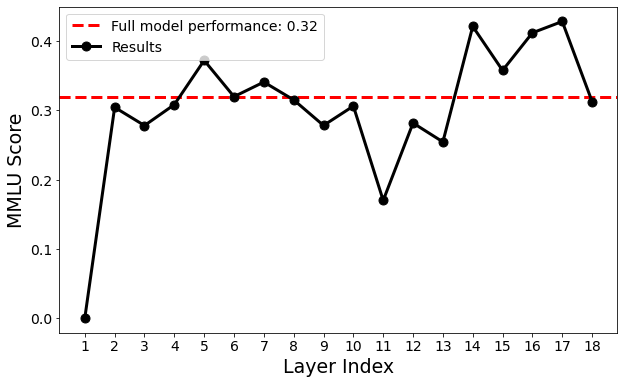

In [109]:
results = read_result('./results/resultsMMLU.txt')
# First value for the horizontal dashed line
first_value = results[0]

# Values for the line chart (skipping the first value)
y_values = results[1:]
x_values = list(range(1, len(y_values) + 1))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the horizontal dashed line
plt.axhline(y=first_value, color='r', linestyle='--', linewidth=3, label=f'Full model performance: {first_value:.2f}')

# Plot the rest of the values
plt.plot(x_values, y_values, 'o-', linewidth=3, markersize=9, color='black', label='Results')

# Add labels and title with increased font size
plt.xlabel('Layer Index', fontsize=19)
plt.ylabel('MMLU Score', fontsize=19)
#plt.title('Results of MMLU Evaluation', fontsize=22)
plt.legend(fontsize=14)

# Set x-axis ticks to be integers
plt.xticks(x_values, fontsize=14)
plt.yticks(fontsize=14)

# Save the plot as a PDF with a transparent background
output_path = './results/resultsMMLU4_plot.pdf'
plt.savefig(output_path, transparent=True, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()

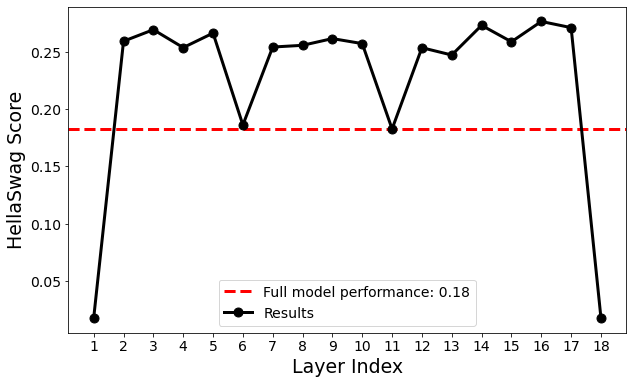

In [112]:
results = read_result('./results/resultsHS.txt')
# First value for the horizontal dashed line
first_value = results[0]

# Values for the line chart (skipping the first value)
y_values = results[1:]
x_values = list(range(1, len(y_values) + 1))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the horizontal dashed line
plt.axhline(y=first_value, color='r', linestyle='--', linewidth=3, label=f'Full model performance: {first_value:.2f}')

# Plot the rest of the values
plt.plot(x_values, y_values, 'o-', linewidth=3, markersize=9, color='black', label='Results')

# Add labels and title with increased font size
plt.xlabel('Layer Index', fontsize=19)
plt.ylabel('HellaSwag Score', fontsize=19)
#plt.title('Results of MMLU Evaluation', fontsize=22)
plt.legend(fontsize=14)

# Set x-axis ticks to be integers
plt.xticks(x_values, fontsize=14)
plt.yticks(fontsize=14)

# Save the plot as a PDF with a transparent background
output_path = './results/resultsHS_plot.pdf'
plt.savefig(output_path, transparent=True, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()

Failed to read resultsMMLU_plot.pdf: 'utf-8' codec can't decode byte 0xac in position 10: invalid start byte


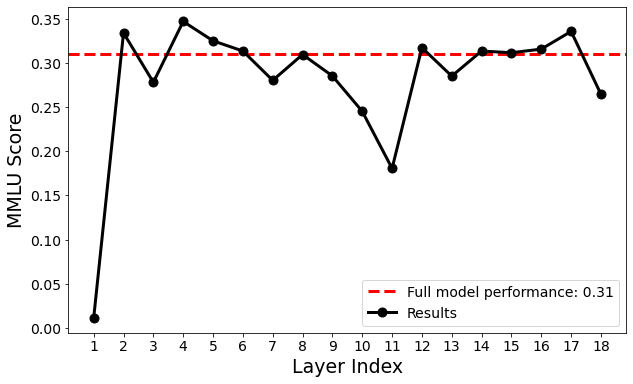

In [228]:
# File path
res_path = f'./results'
# Read the results
results = read_results(res_path)

# Calculate means and standard errors
means = np.mean(results, axis=0)
std_errors = np.std(results, axis=0) / np.sqrt(len(results))

# First value for the horizontal dashed line (mean of the first values)
first_value_mean = means[0]
first_value_stderr = std_errors[0]

# Values for the line chart (skipping the first value)
y_values = means[1:]
y_errors = std_errors[1:]
x_values = list(range(1, len(y_values) + 1))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the horizontal dashed line for the first value
plt.axhline(y=first_value_mean, color='r', linestyle='--', linewidth=3, label=f'Full model performance: {first_value_mean:.2f}')
# Add a shaded area for the standard error around the first value
#plt.fill_between(x_values, first_value_mean - first_value_stderr, first_value_mean + first_value_stderr, color='r', alpha=0.2)

# Plot the rest of the values with error bars
plt.plot(x_values, y_values, 'o-', linewidth=3, markersize=9, color='black', label='Score without layer i')
#plt.errorbar(x_values, y_values, yerr=y_errors, fmt='o-', linewidth=3, markersize=9, label='Results', ecolor='gray', capsize=5)

# Add labels and title with increased font size
plt.xlabel('Layer Index', fontsize=19)
plt.ylabel('MMLU Score', fontsize=19)
#plt.title('Results of MMLU Evaluation', fontsize=22)
plt.legend(fontsize=14)

# Set x-axis ticks to be integers
plt.xticks(x_values, fontsize=14)
plt.yticks(fontsize=14)

# Save the plot as a PDF with a transparent background
output_path = './results/resultsMMLU4_plot.pdf'
plt.savefig(output_path, transparent=True, bbox_inches='tight', format='pdf')

# Show the plot
plt.show()


### MATRIX VISULIZATION

In [7]:
def parse_txt_to_matrix(file_path, config):
    matrix_size = config.num_hidden_layers
    # Initialize an empty matrix
    matrix = np.zeros((matrix_size, matrix_size))
    with open(file_path, "r") as file:
        txt_content = file.read()
    # Parse the content line by line
    lines = txt_content.strip().split("\n")
    for line in lines:
        # Split the line at ':' to separate indices and value
        index_value_pair = line.split(':')
        indices = index_value_pair[0]
        value = float(index_value_pair[1])

        # Split indices at '-' to get row and column indices
        row_index, col_index = map(int, indices.split('-'))

        # Assign the value to the respective place in the matrix
        matrix[row_index, col_index] = value
        matrix[col_index, row_index] = value

    return matrix

def read_result(file_path):
    try:
        with open(file_path, "r") as file:
            lines = file.readlines()
            results = [float(line.strip()) for line in lines]
    except Exception as e:
        print(f"Failed to read {file_path}")
    return results

In [44]:
def get_lower_tri_heatmap(df, reference, output="./results/matrix3.pdf"):

    # Creating a mask for the upper triangle
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Keeping diagonal elements unmasked
    mask[np.diag_indices_from(mask)] = False

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap and reverse it
    cmap = sns.color_palette("magma", as_cmap=True) #sns.diverging_palette(0, 255, sep=40, as_cmap=True) #sns.cubehelix_palette(start=2, rot=0, dark=0.3, light=0.8, reverse=True, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(df - reference, mask=mask, cmap=cmap, vmax=.1, vmin=-0.3, #center=0,
                           square=True, linewidths=.5, cbar_kws={'label': 'MMLU score difference to model with all layers'},# annot=True, fmt=".3f",
                           xticklabels=np.arange(1, len(df)+1), yticklabels=np.arange(1, len(df)+1))

     # Adding texture to the diagonal elements using hatching
    patches = []
    for i in range(len(df)):
        patch = plt.Rectangle((i, i), 1, 1, fill=False, hatch='//', edgecolor='black', lw=0)
        sns_plot.add_patch(patch)
        patches.append(patch)  # Save patch for legend

    # Create legend
    ax.legend(patches, ['Highlighted nodes correspond to only skipping one layer'], bbox_to_anchor=(1.05,1), loc='upper right', handleheight=2, handlelength=2)
    # Save the figure to file
    fig = sns_plot.get_figure()
    fig.savefig(output, transparent=True)



In [45]:
# Set global font size
plt.rcParams.update({'font.size': 14})
resmat = parse_txt_to_matrix('./results/resultsMMLU2layersout.txt', config)
one_layer_res = read_result('./results/resultsMMLU.txt')
reference_value = one_layer_res.pop(0)
np.fill_diagonal(resmat, one_layer_res)

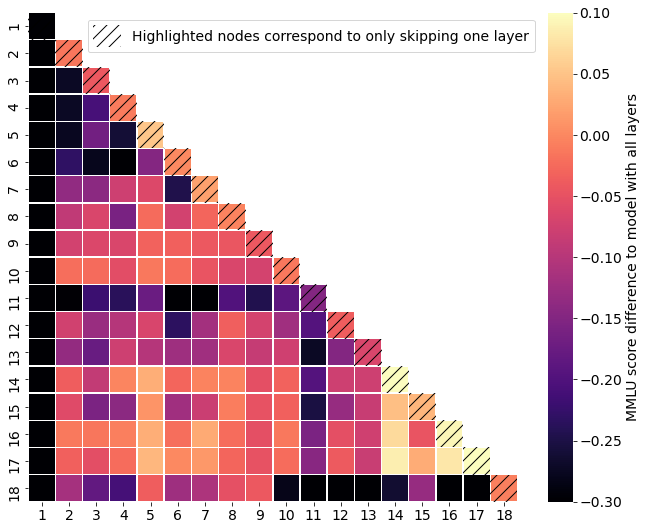

In [46]:
get_lower_tri_heatmap(resmat, reference_value)

### MATRIX V2

In [5]:
def parse_txt_to_matrix(file_path, config):
    matrix_size = config.num_hidden_layers
    # Initialize an empty matrix
    matrix = np.zeros((matrix_size, matrix_size))
    with open(file_path, "r") as file:
        txt_content = file.read()
    # Parse the content line by line
    lines = txt_content.strip().split("\n")
    for i, line in enumerate(lines):
        if i == 0:
            ref_value = float(line)
        else:
            # Split the line at ':' to separate indices and value
            index_value_pair = line.split(':')
            indices = index_value_pair[0]
            value = float(index_value_pair[1])

            # Split indices at '-' to get row and column indices
            row_index, col_index = map(int, indices.split('-'))

            # Assign the value to the respective place in the matrix
            matrix[row_index, col_index] = value
            matrix[col_index, row_index] = value

    return ref_value, matrix

In [35]:
def get_lower_tri_heatmap(reference, df, output="./results/matrixv2.pdf"):

    # Creating a mask for the upper triangle
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Keeping diagonal elements unmasked
    mask[np.diag_indices_from(mask)] = False

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap and reverse it
    cmap = sns.color_palette("Blues_r", as_cmap=True) #sns.diverging_palette(0, 255, sep=40, as_cmap=True) #sns.cubehelix_palette(start=2, rot=0, dark=0.3, light=0.8, reverse=True, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(df - reference, mask=mask, cmap=cmap, vmax=0, #vmin=-0.3, #center=0,
                           square=True, linewidths=.5, cbar_kws={'label': 'MMLU score difference to model with all layers'},# annot=True, fmt=".3f",
                           xticklabels=np.arange(1, len(df)+1), yticklabels=np.arange(1, len(df)+1))

     # Adding texture to the diagonal elements using hatching
    patches = []
    for i in range(len(df)):
        patch = plt.Rectangle((i, i), 1, 1, fill=False, hatch='//', edgecolor='black', lw=0)
        sns_plot.add_patch(patch)
        patches.append(patch)  # Save patch for legend

    # Create legend
    ax.legend(patches, ['Highlighted nodes correspond to only skipping one layer'], bbox_to_anchor=(1.05,1), loc='upper right', handleheight=2, handlelength=2)
    # Save the figure to file
    fig = sns_plot.get_figure()
    fig.savefig(output, transparent=True)



In [36]:
# Set global font size
plt.rcParams.update({'font.size': 14})
reference_value, resmat = parse_txt_to_matrix('./results/resultsMMLU1.txt', config)

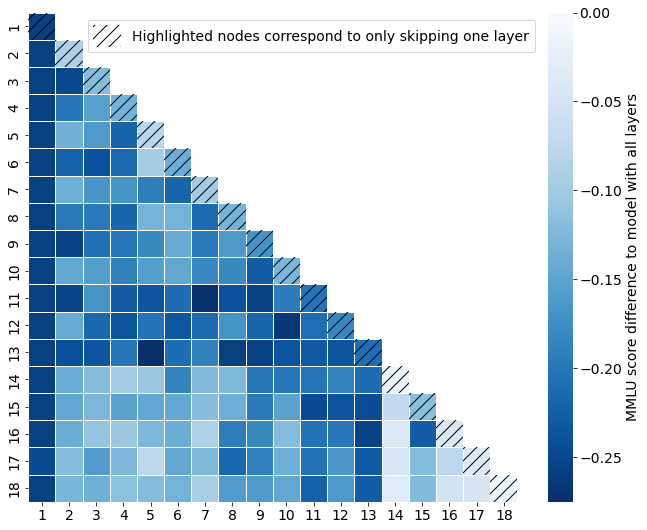

In [37]:
get_lower_tri_heatmap(reference_value, resmat)

### TRAFFIC

In [2]:
from scapy.all import IP, TCP, UDP, rdpcap  # Import necessary modules for packet manipulation
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For enhanced graph styling
import math

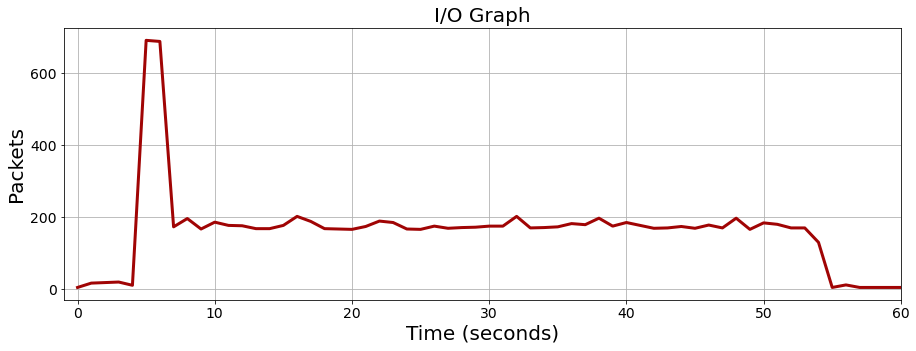

In [4]:
plt.rcParams.update({'font.size': 30})
# Function to plot the throughput over time based on the network traffics data
def produce_io_graph_scapy(pcap_file):

    # Lists to store data for plotting
    time_intervals_list = []  # List to store timestamps
    packets_sent_list = []     # List to store packet counts

    # Dictionary to store packet counts for each timestamp
    packet_dict = dict()

    start_time = pcap_file[0].time  # Capture the start time of the first packet for relative timing
    
    # Iterate through each packet in the pcap file
    for packet in pcap_file:
        if IP in packet:  # Check if the packet has an IP layer

            # Calculate the relative arrival time for each packet
            exact_timestamp = packet.time - start_time

        # Check for TCP or UDP layers and extract source and destination ports
        if TCP in packet:
            src_port = packet[TCP].sport
            dst_port = packet[TCP].dport
        elif UDP in packet:
            src_port = packet[UDP].sport
            dst_port = packet[UDP].dport
            
        # Collect inter-arrival times for uplink and downlink packets based on IP addresses
        if src_port and dst_port:
            # Convert timestamp to float and round down to nearest integer
            timestamp = math.floor(float(exact_timestamp))

            # Update count for the timestamp
            if timestamp in packet_dict:
                packet_dict[timestamp] += 1
            else:
                packet_dict[timestamp] = 1

    # Populate lists for plotting from the dictionary
    for key, item in packet_dict.items():
            
        time_intervals_list.append(key)
        packets_sent_list.append(item)
    
    plt.figure(figsize=(15, 5))
    # Plot the I/O graph
    plt.plot(time_intervals_list, packets_sent_list, color='#a00404', linewidth=3)

    # Adding labels and title to the plot
    plt.xlabel('Time (seconds)', fontsize=20)
    plt.ylabel('Packets', fontsize=20)
    plt.title('I/O Graph', fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlim(-1, 60)
    # Display the grid on the plot
    plt.grid(True)
    plt.savefig('./results/rec2.pdf', transparent=True)
    # Show the plot
    plt.show()
    
# Load the PCAP file
file_path = './experiments/rec2.pcap'
pcap = rdpcap(file_path)

# Call each function to visualize IO Graph for uplink, downlink, and both
produce_io_graph_scapy(pcap)

## FORMATTING

In [131]:
model_input = """The following are multiple choice questions (with answers) about clinical knowledge.

The energy for all forms of muscle contraction is provided by:
A. ATP.
B. ADP.
C. phosphocreatine.
D. oxidative phosphorylation.
Answer: A

What is the difference between a male and a female catheter?
A. Male and female catheters are different colours.
B. Male catheters are longer than female catheters.
C. Male catheters are bigger than female catheters.
D. Female catheters are longer than male catheters.
Answer: B

In the assessment of the hand function which of the following is true?
A. Abduction of the thumb is supplied by spinal root T2
B. Opposition of the thumb by opponens policis is supplied by spinal root T1
C. Finger adduction is supplied by the median nerve
D. Finger abduction is mediated by the palmar interossei
Answer: B

How many attempts should you make to cannulate a patient before passing the job on to a senior colleague, according to the medical knowledge of 2020?
A. 4
B. 3
C. 2
D. 1
Answer: C

Glycolysis is the name given to the pathway involving the conversion of:
A. glycogen to glucose-1-phosphate.
B. glycogen or glucose to fructose.
C. glycogen or glucose to pyruvate or lactate.
D. glycogen or glucose to pyruvate or acetyl CoA.
Answer: C

Why would you need to carry out a bladder washout for a patient at home?
A. When their urine is clear.
B. When the catheter is blocked.
C. When the catheter is bypassing.
D. When the catheter is dirty.
Answer:Output 'A', 'B', 'C', or 'D'. Full answer not needed."""

In [145]:
def format_prompt(text):
    # Split the text into sections based on question starts
    questions = text.split('\n\n')
    # This will hold the final formatted text
    prepend = "Please read the following questions carefully and select the best answer on the last question based on logical reasoning and factual knowledge. Your goal is to identify the most accurate and scientifically valid response. "
    formatted_text = [prepend + questions[0]]
    
    # We use regex to capture the questions and their answers
    pattern = r"(.*?Answer: )([ABCD])(\n|$)"
    # Process each section
    for section in questions[1:-1]:
        # Find all the parts that need to be modified
        # This finds all questions and their answers
        matches = re.findall(pattern, section, re.DOTALL)
        # We process all matches except the last one as regular Q&A
        question, answer, end = matches[0]
        replacement = f"<start_of_turn>user\n{question}<end_of_turn><start_of_turn>model\n{answer}<end_of_turn>"
        #formatted_section = formatted_section.replace(question + 'Answer: ' + answer + end, replacement)

        # Append the formatted section to the result
        formatted_text.append(replacement)
    # For the last question, we do not need the model's answer part
    last_question = questions[-1]
    pattern = r"^(.*?Answer:)(.*)$"
    matches = re.findall(pattern, last_question, re.DOTALL)
    # We process all matches except the last one as regular Q&A
    question, end = matches[0]
    last_replacement = f"<start_of_turn>user\n{question} <end_of_turn>"
    formatted_text.append(last_replacement)
    return "\n\n".join(formatted_text)
print(format_prompt(model_input))

Please read the following questions carefully and select the best answer on the last question based on logical reasoning and factual knowledge. Your goal is to identify the most accurate and scientifically valid response. The following are multiple choice questions (with answers) about clinical knowledge.

<start_of_turn>user
The energy for all forms of muscle contraction is provided by:
A. ATP.
B. ADP.
C. phosphocreatine.
D. oxidative phosphorylation.
Answer: <end_of_turn><start_of_turn>model
A<end_of_turn>

<start_of_turn>user
What is the difference between a male and a female catheter?
A. Male and female catheters are different colours.
B. Male catheters are longer than female catheters.
C. Male catheters are bigger than female catheters.
D. Female catheters are longer than male catheters.
Answer: <end_of_turn><start_of_turn>model
B<end_of_turn>

<start_of_turn>user
In the assessment of the hand function which of the following is true?
A. Abduction of the thumb is supplied by spinal

In [14]:
tokenizer = Tokenizer(config.tokenizer)

In [22]:
options = ['A', 'B', 'C', 'D']
opt_ixs = [tokenizer.encode(letter)[1] for letter in options]
opt_ixs

[235280, 235305, 235288, 235299]

In [23]:
[tokenizer.decode(letter) for letter in opt_ixs]

['A', 'B', 'C', 'D']

## Experiment with fluidness of the model

In [17]:
class GemmaForCausalLM(nn.Module):
    def __init__(
        self,
        config: gemma_config.GemmaConfig,
    ):
        super().__init__()
        self.config = config
        assert config.hidden_size % config.num_attention_heads == 0

        max_seq_len = config.max_position_embeddings
        head_dim = config.head_dim
        vocab_size = config.vocab_size

        self.tokenizer = Tokenizer(config.tokenizer)
        self.embedder = self.initialize_embedder(vocab_size)
        self.model = self.initialize_model()
        self.sampler = Sampler(vocab_size).to(device)

        # Pre-compute rotary embedding table.
        rope_theta = getattr(config, 'rope_theta', 10000)
        self.freqs_cis = precompute_freqs_cis(head_dim,
                                         max_seq_len * 2,
                                         theta=rope_theta).to(device)
        
    def initialize_model(
        self,
    ):
        # Initialize and load splits
        model = [GemmaLayerModel(self.config) for layer in range(self.config.num_hidden_layers - 1)]
        model.append(GemmaLastLayerModel(self.config))
        for layer in range(self.config.num_hidden_layers):
            load_model(model[layer], f'./weights/{VARIANT}/layer_model_{layer}.pth')
        model = [layer.to(device).eval() for layer in model]
        return model

    def initialize_embedder(
        self,
        vocab_size
    ):
        # Initialize embedder
        embedder = Embedding(vocab_size, self.config.hidden_size, self.config.quant).to(device)
        embedding_weights = torch.load(f'./weights/{VARIANT}/embedding_weights.pth', map_location=device)
        embedder.load_state_dict(embedding_weights)
        return embedder

    def forward_pass(
        self,
        output_index,
        j, # Layer to skip if not none
        input_token_ids: torch.Tensor,
        input_positions: torch.Tensor,
        kv_write_indices: torch.Tensor,
        kv_caches: List[Tuple[torch.Tensor, torch.Tensor]],
        mask: torch.Tensor,
        output_positions: torch.Tensor,
        temperatures: Union[torch.Tensor, None],
        top_ps: torch.Tensor,
        top_ks: torch.Tensor,
        **kwargs,
    ) -> torch.Tensor:
        freqs_cis = self.freqs_cis.index_select(0, input_positions)
        kv_write_indices = input_positions

        # [batch_size, input_len, hidden_size]
        hidden_states = self.embedder(input_token_ids)
        # Gemma normalizes the embedding by sqrt(hidden_size).
        hidden_states = hidden_states * (self.config.hidden_size**0.5)
        with torch.no_grad():
            for i in range(self.config.num_hidden_layers):
                if j is not None and i in j:
                    #print(f'Skipped layer {i}')
                    continue
                hidden_states = self.model[i](
                    hidden_states=hidden_states,
                    freqs_cis=freqs_cis,
                    kv_write_indices=kv_write_indices,
                    kv_cache=kv_caches[i],
                    mask=mask,
                )
        embedder_weight = self.embedder.weight
        if self.config.quant:
            embedder_weight = (
                embedder_weight * self.embedder.weight_scaler.unsqueeze(-1))
        next_tokens = self.sampler(
            embedding=embedder_weight,
            hidden_states=hidden_states,
            output_positions=output_positions,
            temperatures=temperatures,
            top_ps=top_ps,
            top_ks=top_ks,
        )
        return next_tokens

    def generate(
        self,
        prompts: Union[str, Sequence[str]],
        device: Any,
        lts: Union[int, Sequence[int], None],
        output_len: int = 100,
        temperature: Union[float, None] = 0.95,
        top_p: float = 1.0,
        top_k: int = 100,
    ) -> Union[str, Sequence[str]]:
        """Generates responses for given prompts using Gemma model."""
        # If a single prompt is provided, treat it as a batch of 1.
        is_str_prompt = isinstance(prompts, str)
        if is_str_prompt:
            prompts = [prompts]
        is_lts_int = isinstance(lts, int)
        if is_lts_int:
            lts = [lts]

        batch_size = len(prompts)
        prompt_tokens = [self.tokenizer.encode(prompt) for prompt in prompts]
        min_prompt_len = min(len(p) for p in prompt_tokens)
        max_prompt_len = max(len(p) for p in prompt_tokens)
        max_seq_len = max_prompt_len + output_len
        assert max_seq_len <= self.config.max_position_embeddings

        # build KV caches
        kv_caches = []
        for _ in range(self.config.num_hidden_layers):
            size = (batch_size, max_seq_len, self.config.num_key_value_heads,
                    self.config.head_dim)
            dtype = self.config.get_dtype()
            k_cache = torch.zeros(size=size, dtype=dtype, device=device)
            v_cache = torch.zeros(size=size, dtype=dtype, device=device)
            kv_caches.append((k_cache, v_cache))

        # prepare inputs
        token_ids_tensor = torch.full((batch_size, max_seq_len),
                                      self.tokenizer.pad_id, dtype=torch.int64)
        input_token_ids_tensor = torch.full((batch_size, min_prompt_len),
                                            self.tokenizer.pad_id,
                                            dtype=torch.int64)
        for i, p in enumerate(prompt_tokens):
            token_ids_tensor[i, :len(p)] = torch.tensor(p)
            input_token_ids_tensor[i, :min_prompt_len] = torch.tensor(
                p[:min_prompt_len])
        token_ids_tensor = token_ids_tensor.to(device)
        input_token_ids_tensor = input_token_ids_tensor.to(device)
        prompt_mask_tensor = token_ids_tensor != self.tokenizer.pad_id
        input_positions_tensor = torch.arange(0, min_prompt_len,
                                              dtype=torch.int64).to(device)
        mask_tensor = torch.full((1, 1, max_seq_len, max_seq_len),
                                 -2.3819763e38).to(torch.float)
        mask_tensor = torch.triu(mask_tensor, diagonal=1).to(device)
        curr_mask_tensor = mask_tensor.index_select(2, input_positions_tensor)
        output_positions_tensor = torch.LongTensor([min_prompt_len - 1]).to(
            device)
        temperatures_tensor = None if not temperature else torch.FloatTensor(
            [temperature] * batch_size).to(device)
        top_ps_tensor = torch.FloatTensor([top_p] * batch_size).to(device)
        top_ks_tensor = torch.LongTensor([top_k] * batch_size).to(device)
        output_index = torch.tensor(min_prompt_len, dtype=torch.int64).to(
            device)

        # Prefill up to min_prompt_len tokens, then treat other prefill as
        # decode and ignore output.
        for i in range(max_seq_len - min_prompt_len):
            next_token_ids = self.forward_pass(
                output_index,
                lts,
                input_token_ids=input_token_ids_tensor,
                input_positions=input_positions_tensor,
                kv_write_indices=None,
                kv_caches=kv_caches,
                mask=curr_mask_tensor,
                output_positions=output_positions_tensor,
                temperatures=temperatures_tensor,
                top_ps=top_ps_tensor,
                top_ks=top_ks_tensor,
            )

            curr_prompt_mask = prompt_mask_tensor.index_select(
                1, output_index).squeeze(dim=1)
            curr_token_ids = token_ids_tensor.index_select(
                1, output_index).squeeze(dim=1)
            output_token_ids = torch.where(curr_prompt_mask, curr_token_ids,
                                           next_token_ids).unsqueeze(dim=1)
            token_ids_tensor.index_copy_(1, output_index, output_token_ids)

            input_token_ids_tensor = output_token_ids
            input_positions_tensor = output_index.unsqueeze(dim=-1)
            curr_mask_tensor = mask_tensor.index_select(2,
                                                        input_positions_tensor)
            output_positions_tensor = torch.tensor(0, dtype=torch.int64).to(
                device)
            output_index = output_index + 1

        # Detokenization.
        token_ids = token_ids_tensor.tolist()
        results = []
        for i, tokens in enumerate(token_ids):
            trimmed_output = tokens[len(prompt_tokens[i]):len(prompt_tokens[i])
                                    + output_len]
            if self.tokenizer.eos_id in trimmed_output:
                eos_index = trimmed_output.index(self.tokenizer.eos_id)
                trimmed_output = trimmed_output[:eos_index]
            results.append(self.tokenizer.decode(trimmed_output))

        # If a string was provided as input, return a string as output.
        return results[0] if is_str_prompt else results

In [20]:
# Chat templates
USER_CHAT_TEMPLATE = '<start_of_turn>user\n{prompt}<end_of_turn>\n'
MODEL_CHAT_TEMPLATE = '<start_of_turn>model\n{prompt}<end_of_turn>\n'

# Sample formatted prompt
prompt = (
    USER_CHAT_TEMPLATE.format(
        prompt='What is the best city in Europe?'
    )
    + MODEL_CHAT_TEMPLATE.format(prompt='Barcelona.')
    + USER_CHAT_TEMPLATE.format(prompt='What can I do in Barcelona?')
    + '<start_of_turn>model\n'
)
print('Chat prompt:\n', prompt)

gemma2B = GemmaForCausalLM(config)

Chat prompt:
 <start_of_turn>user
What is the best city in Europe?<end_of_turn>
<start_of_turn>model
Barcelona.<end_of_turn>
<start_of_turn>user
What can I do in Barcelona?<end_of_turn>
<start_of_turn>model



normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [22]:
print("Original prompt:\n")
print(prompt)
response = gemma2B.generate(
    prompts=USER_CHAT_TEMPLATE.format(prompt=prompt),  # use the keyword for prompts
    device=device,
    lts=None,
    output_len=50
)
print("Full model response:\n", response)
# Skipping one layer
# Skipping layers
for i in range(config.num_hidden_layers):
    response = gemma2B.generate(
        prompts=USER_CHAT_TEMPLATE.format(prompt=prompt),  # use the keyword for prompts
        device=device,
        lts=i,
        output_len=50
    )
    print(f"Layer skipped {i}:\n", response)
# Skipping two layers
for i in range(config.num_hidden_layers):
    for j in range(i+1, config.num_hidden_layers):
        response = gemma2B.generate(
            prompts=USER_CHAT_TEMPLATE.format(prompt=prompt),  # use the keyword for prompts
            device=device,
            lts=[i, j],
            output_len=50
        )
        print(f"Layers skipped are {i} and {j}:\n", response)


Original prompt:
<start_of_turn>user
What is the best city in Europe?<end_of_turn>
<start_of_turn>model
Barcelona.<end_of_turn>
<start_of_turn>user
What can I do in Barcelona?<end_of_turn>
<start_of_turn>model

Full model response:  **Top attractions and activities in Barcelona:**

**Historic Sites and Museums:**

- Sagrada Familia
- Park Güell
- Casa Batlló
- Gothic Quarter
- Museu Picasso
- Barcelona Cathedral

**Beaches:**

- Barcel
Layer skipped 0:  Barcelona is a vibrant and modern city, offering a wide range of experiences and opportunities.

**Here are some of the best cities in Barcelona:**:**:**:**:**:**:**:**:**:**:**:**:**:**:**:**:**:**:**:**:**:**
Layer skipped 1:  **Top attractions in Barcelona:**

* Sagrada Familia
* Park Güell
* Casa Batlló
* Museu Nacional d'Art de Catalunya
* Gothic Quarter
* Zona Franca
* Barceloneta Beach
* Montjuïc Castle

Layer skipped 2:  **Top activities in Barcelona:**

**Historical and cultural experiences:**
- Visit the Sagrada Familia, Gaudi